# Time Series problem: Predvidjanje kretanja prodaja u zavistonsti od razlicitih scenarija

- **Trend:** `flat` (neutral), `up` (rising), `down` (falling)  
- **Seasonality:** `none`, `monthly`, `yearly`, `monthly+yearly`

U obzir su uzeti i neradni dani u Srbiji u skadu sa zakonom
Takodje postoje i scenariji sa nepravilnim unosom podataka.


## 1) Import biblioteka

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date, timedelta

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

np.random.seed(42)


## 2) Generisanje neradnih dana

In [2]:
def orthodox_easter_gregorian(year: int) -> date:
    """Proracun za pravoslavni uskrs, posto se menja svake godine"""
    a = year % 4
    b = year % 7
    c = year % 19
    d = (19 * c + 15) % 30
    e = (2 * a + 4 * b - d + 34) % 7
    month = (d + e + 114) // 31
    day_ = ((d + e + 114) % 31) + 1
    julian_easter = date(year, month, day_)
    return julian_easter + timedelta(days=13)  # Julian -> Gregorian for 1900–2099

def serbia_public_holidays(year: int) -> dict[date, str]:
    """Drzavni praznici zajedno sa uskrsom"""
    holidays = {
        date(year, 1, 1): "New Year's Day",
        date(year, 1, 2): "New Year's Day",
        date(year, 1, 7): "Julian Orthodox Christmas",
        date(year, 2, 15): "Statehood Day",
        date(year, 2, 16): "Statehood Day",
        date(year, 5, 1): "Labour Day",
        date(year, 5, 2): "Labour Day",
        date(year, 11, 11): "Armistice Day",
    }

    easter = orthodox_easter_gregorian(year)
    holidays.update({
        easter + timedelta(days=-2): "Orthodox Good Friday",
        easter + timedelta(days=-1): "Orthodox Holy Saturday",
        easter + timedelta(days=0): "Orthodox Easter Sunday",
        easter + timedelta(days=1): "Orthodox Easter Monday",
    })

    # Zakon: Ako jedan od datuma kada se praznuju državni praznici Republike Srbije padne u nedelju, ne radi se prvog narednog radnog dana.
    state_holidays = {"New Year's Day", "Statehood Day", "Labour Day", "Armistice Day"}
    all_dates = set(holidays.keys())

    non_rel_dates = [d for d, name in holidays.items() if name in state_holidays]
    for d in sorted(non_rel_dates):
        if d.weekday() == 6:  # Sunday
            obs = d + timedelta(days=1)
            while obs.weekday() >= 5 or obs in all_dates:
                obs += timedelta(days=1)
            holidays[obs] = holidays[d] + " (observed)"
            all_dates.add(obs)

    return holidays

def serbia_holiday_map_for_range(start: str, end: str) -> dict[pd.Timestamp, str]:
    """Return {Timestamp: name} for all holidays between start and end (inclusive)."""
    start_dt = pd.Timestamp(start).date()
    end_dt = pd.Timestamp(end).date()
    years = range(start_dt.year, end_dt.year + 1)
    out = {}
    for y in years:
        for d, name in serbia_public_holidays(y).items():
            if start_dt <= d <= end_dt:
                out[pd.Timestamp(d)] = name
    return out

# Quick demo: list holidays in 2026
demo = serbia_public_holidays(2026)
sorted(list(demo.items()))[:]


[(datetime.date(2026, 1, 1), "New Year's Day"),
 (datetime.date(2026, 1, 2), "New Year's Day"),
 (datetime.date(2026, 1, 7), 'Julian Orthodox Christmas'),
 (datetime.date(2026, 2, 15), 'Statehood Day'),
 (datetime.date(2026, 2, 16), 'Statehood Day'),
 (datetime.date(2026, 2, 17), 'Statehood Day (observed)'),
 (datetime.date(2026, 4, 10), 'Orthodox Good Friday'),
 (datetime.date(2026, 4, 11), 'Orthodox Holy Saturday'),
 (datetime.date(2026, 4, 12), 'Orthodox Easter Sunday'),
 (datetime.date(2026, 4, 13), 'Orthodox Easter Monday'),
 (datetime.date(2026, 5, 1), 'Labour Day'),
 (datetime.date(2026, 5, 2), 'Labour Day'),
 (datetime.date(2026, 11, 11), 'Armistice Day')]

## 3) Generisanje podataka na osnovu trendova

In [3]:
def generate_daily_sales(
    start: str = "2023-01-01",
    periods: int = 730,
    base_level: float = 30.0,
    trend: str = "flat",                 # 'flat' | 'up' | 'down'
    seasonality: str = "monthly+yearly", # 'none' | 'monthly' | 'yearly' | 'monthly+yearly'
    weekly_pattern: bool = True,

    close_sundays: bool = True,
    close_saturdays: bool = False,
    close_on_public_holidays: bool = True,

    # Noise / outliers
    noise_scale: float = 0.20,           # multiplicative noise strength
    spike_prob: float = 0.02,            # random spikes (outliers)
    spike_mult_range: tuple = (1.7, 3.5),
    overdispersion_k: float = 12.0,      # lower => more variance; higher => more Poisson-like

    # BAD USER INPUT SCENARIO:
    # user enters weekly totals only once per week (at end of week, not necessarily Friday)
    weekly_batch_input: bool = False,
    weekly_batch_last_k_days: int = 3,   # choose the entry day among the last K days of each week
) -> pd.DataFrame:
    """
    If weekly_batch_input=True:
      - We still generate a realistic *true* daily series (sales_true)
      - Then we convert the observed 'sales' into a once-per-week lump:
        the week sum is entered on a random day among the last K days of the week,
        and other days are set to 0.
    """
    dates = pd.date_range(start=start, periods=periods, freq="D")
    t = np.arange(periods, dtype=float)

    # Trend (smooth)
    if trend == "flat":
        growth_rate = 0.00
    elif trend == "up":
        growth_rate = 0.35
    elif trend == "down":
        growth_rate = -0.25
    else:
        raise ValueError("trend must be one of: 'flat', 'up', 'down'")

    level = base_level * np.power(1.0 + growth_rate, t / 365.25)
    level = np.maximum(1.0, level)

    # Monthly/Yearly seasonality (additive)
    seasonal = np.zeros_like(t)
    if seasonality in ("monthly", "monthly+yearly"):
        seasonal += 0.25 * base_level * np.sin(2 * np.pi * t / 30.4375)
    if seasonality in ("yearly", "monthly+yearly"):
        seasonal += 0.40 * base_level * np.sin(2 * np.pi * t / 365.25)

    # Weekly pattern (multiplicative)
    if weekly_pattern:
        dow = dates.dayofweek.values # vraca niz od vrednosti dana [0-6]
        # Mon..Sun multipliers (example pattern)
        dow_mult = np.array([1.00, 1.03, 1.05, 1.02, 1.12, 1.18, 0.78])
        weekly_mult = dow_mult[dow]
    else:
        weekly_mult = 1.0

    # Serbia public holidays
    hol_map = serbia_holiday_map_for_range(dates.min().strftime("%Y-%m-%d"), dates.max().strftime("%Y-%m-%d"))
    holiday_name = pd.Series(index=dates, data=[hol_map.get(d.normalize(), "") for d in dates], dtype="string")
    is_holiday = holiday_name.ne("") # creates bool array

    # Closed policy
    is_weekend = (dates.dayofweek.values >= 5)
    is_closed = np.zeros(periods, dtype=bool)
    # |= je kao  is_closed = is_closed OR (dates.dayofweek.values == 5)
    if close_saturdays:
        is_closed |= (dates.dayofweek.values == 5)
    if close_sundays:
        is_closed |= (dates.dayofweek.values == 6)
    if close_on_public_holidays:
        is_closed |= is_holiday.values

    # Expected mean (before spikes/noise)
    mu = (level + seasonal) * weekly_mult
    mu = np.maximum(0.1, mu)

    # Random spikes (not on closed days)
    spike = (np.random.rand(periods) < spike_prob) & (~is_closed)
    spike_mult = np.ones(periods)
    spike_mult[spike] = np.random.uniform(spike_mult_range[0], spike_mult_range[1], size=int(spike.sum()))
    mu *= spike_mult

    # Multiplicative noise
    eps = np.random.normal(0.0, noise_scale, size=periods)
    mu_noisy = mu * np.exp(eps)
    mu_noisy = np.maximum(0.0, mu_noisy)

    # Force closed days to zero demand
    mu_noisy[is_closed] = 0.0

    # Sample counts via Negative Binomial (extra variance)
    k = float(overdispersion_k) # larger k value gives smoother results
    sales = np.zeros(periods, dtype=int)
    nz = mu_noisy > 0
    mu_nz = mu_noisy[nz]
    p = k / (k + mu_nz)
    sales[nz] = np.random.negative_binomial(n=k, p=p, size=mu_nz.shape[0]).astype(int)

    # Keep the true daily signal
    sales_true = sales.copy()
    weekly_entry = np.zeros(periods, dtype=bool)

    # BAD INPUT: weekly batch entry at end of week (random day among last K days)
    if weekly_batch_input:
        sales_obs = np.zeros_like(sales_true)
        # Week from Monday..Sunday (ends Sunday)
        wk = dates.to_period("W-SUN")
        for w in pd.unique(wk):
            idx = np.where(wk == w)[0]
            if idx.size == 0:
                continue
            week_total = int(sales_true[idx].sum())

            # choose among last K days in the week (or fewer if week is short at edges)
            k_days = int(max(1, weekly_batch_last_k_days))
            candidates = idx[-k_days:]
            chosen = int(np.random.choice(candidates))

            sales_obs[chosen] = week_total
            weekly_entry[chosen] = True

        sales = sales_obs

    return pd.DataFrame({
        "date": dates,
        "sales": sales,                 # observed sales (may be weekly-batched)
        "sales_true": sales_true,       # underlying true daily sales
        "mu": mu_noisy,                 # expected mean (daily)
        "is_weekend": is_weekend,
        "is_holiday": is_holiday.values,
        "holiday_name": holiday_name.values,
        "is_closed": is_closed,
        "spike": spike,
        "weekly_entry": weekly_entry,   # True on the day user entered weekly total (bad input scenario)
        "weekly_batch_input": weekly_batch_input,
    })

# Smoke tests
generate_daily_sales(trend="up", seasonality="monthly+yearly", periods=30, weekly_batch_input=False).head(),
generate_daily_sales(trend="up", seasonality="monthly+yearly", periods=30, weekly_batch_input=True).head()


,date,sales,sales_true,mu,is_weekend,is_holiday,holiday_name,is_closed,spike,weekly_entry,weekly_batch_input
0,2023-01-01,0,0,0.000000,True,True,New Year's Day,True,False,True,True
1,2023-01-02,0,0,0.000000,False,True,New Year's Day,True,False,False,True
2,2023-01-03,0,0,0.000000,False,True,New Year's Day (observed),True,False,False,True
3,2023-01-04,0,48,47.965692,False,False,,False,False,False,True
4,2023-01-05,0,53,43.046286,False,False,,False,False,False,True


## 4) Kreiranje scenarija (3 trends x 4 seasonalities = 12 clean series + 1 bad user input)

In [4]:
TRENDS = ["flat", "up", "down"]
SEASONALITIES = ["none", "monthly", "yearly", "monthly+yearly"]

scenarios = {}
for tr in TRENDS:
    for seas in SEASONALITIES:
        key = f"{tr}__{seas}"
        scenarios[key] = generate_daily_sales(
            start="2025-01-01",
            periods=3 * 365,
            base_level=35.0,
            trend=tr,
            seasonality=seas,
            weekly_pattern=True,
            close_sundays=True,
            close_saturdays=False,
            close_on_public_holidays=True,
            noise_scale=0.18,
            spike_prob=0.02,
            overdispersion_k=10.0,
            weekly_batch_input=False,
        )

# Single "bad user input" scenario: weekly batch entry at end of week
scenarios["bad_user_input"] = generate_daily_sales(
    start="2025-01-01",
    periods=3 * 365,
    base_level=35.0,
    trend="flat",
    seasonality="monthly+yearly",
    weekly_pattern=True,
    close_sundays=True,
    close_saturdays=False,
    close_on_public_holidays=True,
    noise_scale=0.18,
    spike_prob=0.02,
    overdispersion_k=10.0,
    weekly_batch_input=True,
    weekly_batch_last_k_days=3,   # entry day among last 3 days of week (not necessarily Friday)
)

list(scenarios.keys())[:], len(scenarios)


(['flat__none',
  'flat__monthly',
  'flat__yearly',
  'flat__monthly+yearly',
  'up__none',
  'up__monthly',
  'up__yearly',
  'up__monthly+yearly',
  'down__none',
  'down__monthly',
  'down__yearly',
  'down__monthly+yearly',
  'bad_user_input'],
 13)

## 4b) Cuvanje podataka u CSV fajlove

In [5]:
from pathlib import Path

out_dir = Path("Data")
out_dir.mkdir(parents=True, exist_ok=True)

# After creating full datasets, also export fixed-length subsets for benchmarking
SUBSET_DAYS = [30, 100, 300]     # you can add more here
SUBSET_ANCHOR = "last"           # 'last' or 'first'

saved = 0
saved_sub = 0

for name, df_s in scenarios.items():
    # Full dataset
    df_s.to_csv(out_dir / f"{name}.csv", index=False)
    saved += 1

    # Subsets
    for n in SUBSET_DAYS:
        if len(df_s) < n:
            continue
        df_sub = df_s.tail(n) if SUBSET_ANCHOR == "last" else df_s.head(n)
        suffix = f"{SUBSET_ANCHOR}{n}d"
        df_sub.to_csv(out_dir / f"{name}__{suffix}.csv", index=False)
        saved_sub += 1

print(f"Saved {saved} full scenario CSV files into: {out_dir.resolve()}")
print(f"Saved {saved_sub} subset CSV files (sizes={SUBSET_DAYS}, anchor='{SUBSET_ANCHOR}')")
print("Example files:", sorted([p.name for p in out_dir.glob('*.csv')])[:8])


Saved 13 full scenario CSV files into: /python-roi/python-roi/Data
Saved 39 subset CSV files (sizes=[30, 100, 300], anchor='last')
Example files: ['bad_user_input.csv', 'bad_user_input__last100d.csv', 'bad_user_input__last300d.csv', 'bad_user_input__last30d.csv', 'down__monthly+yearly.csv', 'down__monthly+yearly__last100d.csv', 'down__monthly+yearly__last300d.csv', 'down__monthly+yearly__last30d.csv']


## 5) Vizuelizacija podataka

In [6]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# --- 1) Find CSV files to choose from
data_dir = Path("Data")
data_dir.mkdir(parents=True, exist_ok=True)

csv_files = sorted(data_dir.glob("*.csv"))
if not csv_files:
    print("No CSV files found in ./Data")
    print("Run the scenario generation + saving cell first, OR copy your CSV into ./Data")
else:
    print(f"Found {len(csv_files)} CSV file(s) in ./Data")
    print("Example:", csv_files[0].name)

def load_sales_csv(path: Path) -> pd.DataFrame:
    """Load a CSV with at least: date, sales. Extra columns are kept if present."""
    df = pd.read_csv(path)
    if "date" not in df.columns:
        raise ValueError("CSV must contain a 'date' column")
    if "sales" not in df.columns:
        raise ValueError("CSV must contain a 'sales' column")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")
    return df

def plot_range(df_full: pd.DataFrame, start, end, shade_closed: bool = True, mark_spikes: bool = True):
    """Plot full series + zoomed range + rolling mean."""
    if start is None or end is None:
        return
    start_ts = pd.Timestamp(start)
    end_ts = pd.Timestamp(end)
    if start_ts > end_ts:
        start_ts, end_ts = end_ts, start_ts

    df_zoom = df_full.loc[start_ts:end_ts].copy()

    # Plot A: full series with selected range highlighted
    plt.figure(figsize=(14, 3.5))
    ax = plt.gca()
    ax.plot(df_full.index.to_pydatetime(), df_full["sales"].values, linewidth=1)
    # Trend line (simple linear fit) over the full series
    s_full = df_full["sales"].dropna()
    if len(s_full) >= 2:
        x = np.arange(len(s_full), dtype=float)
        m, b = np.polyfit(x, s_full.values.astype(float), 1)
        trend = m * x + b
        ax.plot(s_full.index.to_pydatetime(), trend, color="red", linewidth=2, label="trend")
    plt.axvspan(start_ts, end_ts + pd.Timedelta(days=1), alpha=0.12)
    plt.title("Full series (selected range highlighted)")
    plt.xlabel("date")
    plt.ylabel("sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot B: zoomed range
    plt.figure(figsize=(14, 4))
    ax = plt.gca()
    ax.plot(df_zoom.index.to_pydatetime(), df_zoom["sales"].values, linewidth=1)

    # Trend line (simple linear fit) over the zoomed window
    s_zoom = df_zoom["sales"].dropna()
    if len(s_zoom) >= 2:
        xz = np.arange(len(s_zoom), dtype=float)
        m2, b2 = np.polyfit(xz, s_zoom.values.astype(float), 1)
        trend2 = m2 * xz + b2
        ax.plot(s_zoom.index.to_pydatetime(), trend2, color="red", linewidth=2, label="trend")
    # Optional: mark spikes if column exists
    if mark_spikes and "spike" in df_zoom.columns:
        spike_days = df_zoom.index[df_zoom["spike"].astype(bool)]
        if len(spike_days) > 0:
            plt.scatter(spike_days.to_pydatetime(), df_zoom.loc[spike_days, "sales"], s=18, label="spike", zorder=3)

    # Optional: mark weekly-entry (bad input) if column exists
    if "weekly_entry" in df_zoom.columns:
        we_days = df_zoom.index[df_zoom["weekly_entry"].astype(bool)]
        if len(we_days) > 0:
            plt.scatter(we_days.to_pydatetime(), df_zoom.loc[we_days, "sales"], s=28, marker="x", label="weekly entry", zorder=4)

    # Optional: shade closed days if column exists
    if shade_closed and "is_closed" in df_zoom.columns:
        closed_days = df_zoom.index[df_zoom["is_closed"].astype(bool)]
        for d in closed_days:
            plt.axvspan(d, d + pd.Timedelta(days=1), alpha=0.08)

    plt.title(f"Zoomed range: {start_ts.date()} → {end_ts.date()}  (rows={len(df_zoom)})")
    plt.xlabel("date")
    plt.ylabel("sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot C: zoomed 7-day rolling mean
    plt.figure(figsize=(14, 3.5))
    ax = plt.gca()
    roll = df_zoom["sales"].rolling(7).mean()
    ax.plot(roll.index.to_pydatetime(), roll.values, linewidth=1)
    plt.title("Zoomed range — 7-day rolling mean (smoother view)")
    plt.xlabel("date")
    plt.ylabel("sales (7d mean)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




Found 52 CSV file(s) in ./Data
Example: bad_user_input.csv


## 5b) Izbor podataka

In [ ]:
import ipywidgets as widgets
from IPython.display import display
    

# This cell builds a small interactive UI (dropdowns + date pickers) so you can:
# 1) choose which CSV file to load from the Data folder
# 2) choose a time window (All / Last N / Custom)
# 3) update a global df_current that later cells (STL / forecasting) will use
#
# Why the refresh loop happened before:
# - start_picker / end_picker were observed (on change -> refresh_plot runs)
# - inside refresh_plot we also set start_picker.value / end_picker.value
# - that setting triggered refresh_plot again (recursive loop)
#
# The fix below uses _set_picker_safely():
# it temporarily disables the observer, sets the picker value, then re-enables the observer.
# That lets us keep the date pickers reactive without infinite recursion.

default_path = csv_files[0]
df_loaded = load_sales_csv(default_path)

# Global df_current used by later cells (STL/forecast). It will be updated to the selected window.
df_current = df_loaded.copy()



file_dd = widgets.Dropdown(
    options=[p.name for p in csv_files],
    value=default_path.name,
    description="CSV:",
    layout=widgets.Layout(width="650px"),
)

window_dd = widgets.Dropdown(
    options=["All", "Last 30", "Last 100", "Last 300", "Custom"],
    value="All",
    description="Window:",
    layout=widgets.Layout(width="250px"),
)

anchor_dd = widgets.Dropdown(
    options=["Last", "First"],
    value="Last",
    description="Anchor:",
    layout=widgets.Layout(width="200px"),
)

start_picker = widgets.DatePicker(description="Start:", value=df_loaded.index.min().date())
end_picker = widgets.DatePicker(description="End:", value=df_loaded.index.max().date())

shade_cb = widgets.Checkbox(value=True, description="Shade closed days (if column exists)")
spikes_cb = widgets.Checkbox(value=True, description="Mark spikes (if column exists)")

out = widgets.Output()

def _set_picker_safely(picker, value):
    """Set DatePicker value without triggering a refresh loop."""
    if picker.value == value:
        return
    try:
        picker.unobserve(refresh_plot, names="value")
    except Exception:
        pass
    picker.value = value
    try:
        picker.observe(refresh_plot, names="value")
    except Exception:
        pass

def _set_dropdown_safely(dropdown, value):
    """Set Dropdown value without triggering nested refresh_plot calls."""
    if dropdown.value == value:
        return
    try:
        dropdown.unobserve(refresh_plot, names="value")
    except Exception:
        pass
    dropdown.value = value
    try:
        dropdown.observe(refresh_plot, names="value")
    except Exception:
        pass

def refresh_plot(*args):
    # If you manually change Start/End DatePicker, switch Window to Custom automatically.
    # Otherwise (All / Last N) the code will overwrite your picked dates with the computed window.
    if args and isinstance(args[0], dict):
        owner = args[0].get("owner", None)
        if owner in (start_picker, end_picker) and window_dd.value != "Custom":
            _set_dropdown_safely(window_dd, "Custom")

    global df_current
    with out:
        out.clear_output(wait=True)
        path = data_dir / file_dd.value
        df_now = load_sales_csv(path)

        min_d = df_now.index.min()
        max_d = df_now.index.max()

        # Decide the window
        if window_dd.value == "All":
            start_ts, end_ts = min_d, max_d
        elif window_dd.value in ("Last 30", "Last 100", "Last 300"):
            n = int(window_dd.value.split()[-1])
            if anchor_dd.value == "Last":
                end_ts = max_d
                start_ts = max(min_d, end_ts - pd.Timedelta(days=n - 1))
            else:
                start_ts = min_d
                end_ts = min(max_d, start_ts + pd.Timedelta(days=n - 1))
        else:
            # Custom: use pickers, but clamp to available range
            sp = pd.Timestamp(start_picker.value) if start_picker.value else min_d
            ep = pd.Timestamp(end_picker.value) if end_picker.value else max_d
            start_ts = max(min_d, min(sp, max_d))
            end_ts = min(max_d, max(ep, min_d))

        # Update date pickers to reflect chosen window (safe: prevents refresh loop)
        if window_dd.value != "Custom":
            _set_picker_safely(start_picker, start_ts.date())
            _set_picker_safely(end_picker, end_ts.date())
# IMPORTANT: df_current becomes the selected window (so STL/forecast uses 30/100/300 days if you choose that)
        df_current = df_now.loc[start_ts:end_ts].copy()

        plot_range(df_now, start_ts, end_ts, shade_closed=shade_cb.value, mark_spikes=spikes_cb.value)

for w in (file_dd, window_dd, anchor_dd, start_picker, end_picker, shade_cb, spikes_cb):
    w.observe(refresh_plot, names="value")

controls = widgets.VBox([
    file_dd,
    widgets.HBox([window_dd, anchor_dd]),
    widgets.HBox([start_picker, end_picker]),
    shade_cb,
    spikes_cb
])
display(controls, out)
refresh_plot()

Output()

## 6) Diagnostics: STL decomposition + ACF (weekly/monthly/yearly signals)

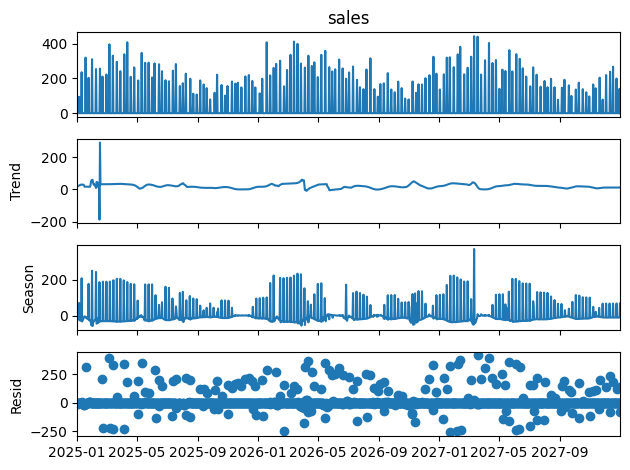

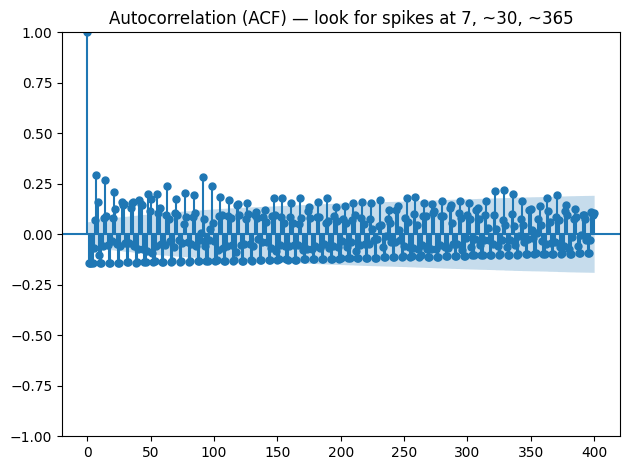

In [8]:
# Uses df_current from the CSV-loading cell (Section 5)
# If you didn't run Section 5 yet, run it first.
try:
    _df = df_current
except NameError:
    raise RuntimeError("df_current is not defined. Run Section 5 (load CSV + choose range) first.")

stl = STL(_df["sales"], period=7, robust=True)
res = stl.fit()
res.plot()
plt.tight_layout()
plt.show()

plot_acf(_df["sales"], lags=400)
plt.title("Autocorrelation (ACF) — look for spikes at 7, ~30, ~365")
plt.tight_layout()
plt.show()


## 7) Optional: simulate missing dates + show two filling strategies

Missing days simulated: 19


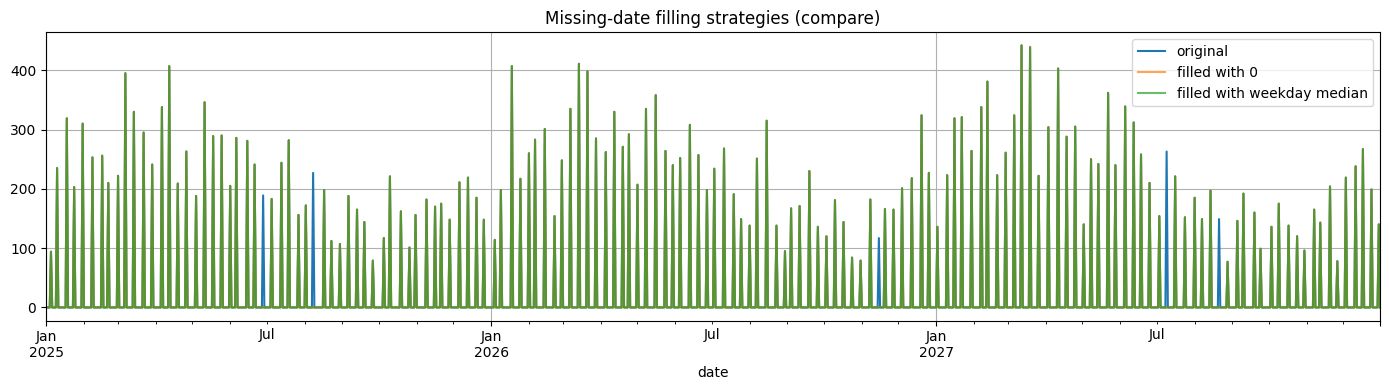

In [9]:
df_obs = df_current.copy()

missing_frac = 0.02
mask_missing = np.random.rand(len(df_obs)) < missing_frac
df_missing = df_obs.loc[~mask_missing].copy()

full_idx = pd.date_range(df_obs.index.min(), df_obs.index.max(), freq="D")
df_missing = df_missing.reindex(full_idx)

print("Missing days simulated:", int(df_missing["sales"].isna().sum()))

# Strategy A: fill missing with 0
df_fill_zero = df_missing.copy()
df_fill_zero["sales"] = df_fill_zero["sales"].fillna(0)

# Strategy B: fill missing with weekday median
df_fill_wkmed = df_missing.copy()
weekday_medians = df_obs.groupby(df_obs.index.dayofweek)["sales"].median()
wk = pd.Series(df_fill_wkmed.index.dayofweek, index=df_fill_wkmed.index)
df_fill_wkmed["sales"] = df_fill_wkmed["sales"].fillna(wk.map(weekday_medians))

plt.figure(figsize=(14, 4))
df_obs["sales"].plot(label="original")
df_fill_zero["sales"].plot(alpha=0.7, label="filled with 0")
df_fill_wkmed["sales"].plot(alpha=0.7, label="filled with weekday median")
plt.title("Missing-date filling strategies (compare)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 8) Example forecasts (ETS + Prophet)

/usr/local/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


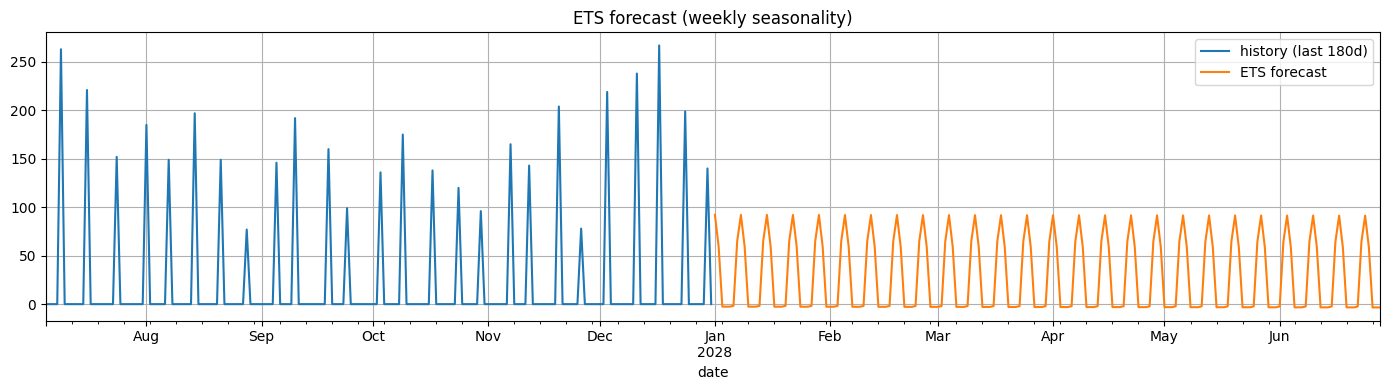

Prophet not available. Install with: pip install prophet
Error: ModuleNotFoundError("No module named 'prophet'")


In [10]:
# Uses df_current from the CSV-loading cell (Section 5)
try:
    _df = df_current
except NameError:
    raise RuntimeError("df_current is not defined. Run Section 5 (load CSV + choose range) first.")

HORIZON_DAYS = 180

ets = ExponentialSmoothing(
    _df["sales"],
    trend="add",
    seasonal="add",
    seasonal_periods=7,
).fit(optimized=True)

ets_forecast = ets.forecast(HORIZON_DAYS)

plt.figure(figsize=(14, 4))
_df["sales"].iloc[-180:].plot(label="history (last 180d)")
ets_forecast.plot(label="ETS forecast")
plt.title("ETS forecast (weekly seasonality)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

try:
    from prophet import Prophet

    df_prophet = df.reset_index().rename(columns={"date": "ds", "sales": "y"})
    m = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        daily_seasonality=False,
    )
    m.fit(df_prophet)

    future = m.make_future_dataframe(periods=HORIZON_DAYS, freq="D")
    fcst = m.predict(future)

    fig = m.plot(fcst)
    plt.title("Prophet forecast")
    plt.tight_layout()
    plt.show()

    _ = m.plot_components(fcst)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Prophet not available. Install with: pip install prophet")
    print("Error:", repr(e))


## Notes on “realism” knobs

- `base_level`: typical daily demand scale (e.g., 5, 30, 200)
- `close_sundays / close_saturdays / close_on_public_holidays`: closure policy for Serbia
- `spike_prob` / `spike_mult_range`: frequency and intensity of outlier surges
- `noise_scale`: random day-to-day variation
- `overdispersion_k`: controls extra variance beyond Poisson (lower → more volatile)
